[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1VWjZceVUqbDEkNOYdxUNsQxZUsyio9i0?usp=sharing)

# Setup

In [ ]:
!pip install sentencepiece
!pip install transformers

     |████████████████████████████████| 1.2MB 2.8MB/s 
     |████████████████████████████████| 2.3MB 2.8MB/s 
     |████████████████████████████████| 3.3MB 14.1MB/s 
     |████████████████████████████████| 901kB 25.4MB/s 


In [ ]:
import time
import datetime
import tensorflow as tf
import torch
import pandas as pd
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, AdamW
from google.colab import drive
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import get_linear_schedule_with_warmup
import numpy as np
import time
import datetime
import random
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import os
from sklearn.metrics import accuracy_score, mean_absolute_error


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

SystemError: ignored

# Fine-Tuning XLM-R for Binary Sentiment Classification

## Load English and Japanese review data obtained from the Amazon Multilingual Review Dataset

In [ ]:
en_train_path = './data/amazon-enja-sentiment-dataset/dataset_en_train.json'
en_dev_path = './data/amazon-enja-sentiment-dataset/dataset_en_dev.json'
ja_train_path = './data/amazon-enja-sentiment-dataset/dataset_ja_train.json'
ja_dev_path = './data/amazon-enja-sentiment-dataset/dataset_ja_dev.json'

In [ ]:
# english
df_en = pd.read_json(en_train_path, lines=True)
# japanese
df_ja = pd.read_json(ja_train_path, lines=True)
df_train = pd.concat([df_en, df_ja])
df_train.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,en_0964290,product_en_0740675,reviewer_en_0342986,1,Arrived broken. Manufacturer defect. Two of th...,I'll spend twice the amount of time boxing up ...,en,furniture
1,en_0690095,product_en_0440378,reviewer_en_0133349,1,the cabinet dot were all detached from backing...,Not use able,en,home_improvement
2,en_0311558,product_en_0399702,reviewer_en_0152034,1,I received my first order of this product and ...,The product is junk.,en,home
3,en_0044972,product_en_0444063,reviewer_en_0656967,1,This product is a piece of shit. Do not buy. D...,Fucking waste of money,en,wireless
4,en_0784379,product_en_0139353,reviewer_en_0757638,1,went through 3 in one day doesn't fit correct ...,bubble,en,pc


## Data Preparation

In [ ]:
#Remove all 3-starred reviews to create a binary sentiment label
df_train = df_train[df_train.stars != 3]
print('Total number of training data: ',df_train.shape[0])

def label_sentiment (row):
    if row['stars'] == 1 or row['stars'] == 2:
      return 0
    elif row['stars'] == 4 or row['stars'] == 5:
      return 1

df_train['sentiment'] = df_train.apply(lambda row: label_sentiment(row), axis=1)
print('Total positive review: ', df_train.loc[df_train['sentiment'] == 1].shape[0])
print('Total negative review: ', df_train.loc[df_train['sentiment'] == 0].shape[0])

Total number of training data:  320000
Total positive review:  160000
Total negative review:  160000


In [ ]:
#Shuffle (and sample, if needed) the data
df_train = df_train.sample(frac=1).reset_index(drop=True)
print(df_train.shape)
df_train

(320000, 9)


,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,sentiment
0,ja_0854542,product_ja_0374307,reviewer_ja_0550958,4,とても可愛いキャミソールでしっかりとしてました。お買取価格でした。,とても可愛い。,ja,apparel,1
1,ja_0070199,product_ja_0893292,reviewer_ja_0560919,1,aptxコーデックで接続できずSBC接続になります。商品説明と異なりますので、返品手続きをします。,aptxコーデックで接続できない,ja,electronics,0
2,en_0801309,product_en_0451203,reviewer_en_0810004,5,Very easy to use and cuts almost all veggies. ...,A must have for all households!,en,kitchen,1
3,en_0358482,product_en_0256780,reviewer_en_0980295,4,I bought the Aomais Life to use in our convert...,"Aomais pairs easily, hold a charge",en,electronics,1
4,en_0152313,product_en_0311737,reviewer_en_0480257,1,Breaks too easily not very durable,Dong buy,en,pc,0
...,...,...,...,...,...,...,...,...,...
319995,en_0734437,product_en_0242860,reviewer_en_0783989,4,"picture clarity is not as good as expected, bu...",serves the purpose of watching my home,en,camera,1
319996,en_0492328,product_en_0891319,reviewer_en_0255321,1,Ironically for a zwave device this paired and ...,Does not register as open every time window is...,en,camera,0
319997,en_0580439,product_en_0807438,reviewer_en_0111559,5,I applied it to my car and it rained the next ...,It works,en,automotive,1
319998,ja_0013266,product_ja_0520782,reviewer_ja_0619626,5,夏休みの自由研究の為に注文しました。 翌日すぐに受け取れたので助かりました。 枚数も多く、使...,枚数が多いので自由研究に最適,ja,industrial_supplies,1


In [ ]:
df_train.loc[df_train['sentiment'] == 1].shape

(160000, 9)

In [ ]:
# Get the lists of reviews and their binary sentiment labels.
reviews = df_train.review_body.values
sentiments = df_train.sentiment.values

## XLM-RoBERTa Tokenizer

In [ ]:
# Download the tokenizer for the XLM-Robert `base` model.
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

In [ ]:
tokenizer

PreTrainedTokenizer(name_or_path='xlm-roberta-base', vocab_size=250002, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)})

In [ ]:
# Print the original sentence.
print(' Original: ', reviews[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(reviews[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(reviews[0])))

 Original:  元々のモニターがそんなに良くなかったので 大分キルできる数が変わりました、 元からゲーミング用のそこそこ高性能なモニターを使っている人ならキルレは上がらないと思いますが 元が良くない人ならこれを買うだけでだいぶ変わると思います
Tokenized:  ['▁', '元', '々の', 'モ', 'ニ', 'ター', 'が', 'そんなに', '良く', 'なかったので', '▁大', '分', 'キ', 'ル', 'できる', '数が', '変わり', 'ました', '、', '▁', '元', 'から', 'ゲー', 'ミ', 'ング', '用の', 'そこ', 'そこ', '高', '性能', 'な', 'モ', 'ニ', 'ター', 'を', '使っている', '人', 'なら', 'キ', 'ル', 'レ', 'は', '上', 'が', 'らない', 'と思いますが', '▁', '元', 'が良く', 'ない', '人', 'なら', 'これ', 'を買う', 'だけで', 'だ', 'い', 'ぶ', '変わる', 'と思います']
Token IDs:  [6, 2954, 95821, 25675, 28289, 17852, 281, 183248, 64274, 143010, 54553, 1583, 14323, 5283, 9885, 142857, 118948, 6465, 37, 6, 2954, 1309, 213907, 17628, 76337, 120038, 90682, 90682, 1395, 37866, 1308, 25675, 28289, 17852, 251, 161504, 487, 10668, 14323, 5283, 11375, 342, 575, 281, 39077, 87916, 6, 2954, 169840, 5397, 487, 10668, 24818, 194323, 40968, 6787, 2111, 28520, 147585, 9700]


## Convert Sentences to Input IDs


In [ ]:
input_ids = []

for sent in reviews:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,          # Truncate all sentences.
                        truncation=True,
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', reviews[0])
print('Token IDs:', input_ids[0])

Original:  元々のモニターがそんなに良くなかったので 大分キルできる数が変わりました、 元からゲーミング用のそこそこ高性能なモニターを使っている人ならキルレは上がらないと思いますが 元が良くない人ならこれを買うだけでだいぶ変わると思います
Token IDs: [0, 6, 2954, 95821, 25675, 28289, 17852, 281, 183248, 64274, 143010, 54553, 1583, 14323, 5283, 9885, 142857, 118948, 6465, 37, 6, 2954, 1309, 213907, 17628, 76337, 120038, 90682, 90682, 1395, 37866, 1308, 25675, 28289, 17852, 251, 161504, 487, 10668, 14323, 5283, 11375, 342, 575, 281, 39077, 87916, 6, 2954, 169840, 5397, 487, 10668, 24818, 194323, 40968, 6787, 2111, 28520, 147585, 9700, 2]


In [ ]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  128


## Pad and truncate our sequences so that they all have the same length, MAX_LEN=64.

In [ ]:
MAX_LEN = 64

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0. 
# "post" indicates that we want to pad and truncate at the end of the sequence, not the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 64 values...

Padding token: "<pad>", ID: 1

Done.


## The attention mask: Makes it explicit which tokens are actual words versus which are padding.

In [ ]:
attention_masks = []

for sent in input_ids:
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [ ]:
# just to check
print(reviews[2])
print(tokenizer.tokenize(reviews[2]))
print(input_ids[2])
print(attention_masks[2])

確かに表面は冷えます。 電源を入れてから5〜6分程した本製品の表面を触ると、ひんやりとしていておお〜っと感動しますが、スマホにつけてもそれほど温度が下がりません。 それにファンから出る熱気が想像以上に熱いです。 ツインファン仕様などの排熱効率化、モバイルバッテリー機能の追加等、後継機に期待です。
['▁', '確かに', '表面', 'は', '冷', 'えます', '。', '▁', '電源', 'を入れて', 'から', '5', '〜', '6', '分', '程', 'した', '本', '製品', 'の', '表面', 'を', '触', 'ると', '、', 'ひ', 'ん', 'やり', 'と', 'していて', 'お', 'お', '〜', 'っと', '感動', 'しますが', '、', 'スマホ', 'に', 'つけ', 'ても', 'それほど', '温度', 'が', '下', 'が', 'りません', '。', '▁', 'それに', 'ファン', 'から', '出', 'る', '熱', '気が', '想像', '以上に', '熱', 'い', 'です', '。', '▁', 'ツ', 'イン', 'ファン', '仕様', 'などの', '排', '熱', '効率', '化', '、', 'モバイル', 'バ', 'ッ', 'テ', 'リー', '機能', 'の', '追加', '等', '、', '後', '継', '機', 'に', '期待', 'です', '。']
[     0      6 107538  51655    342  10359 106535     30      6 116274
 153387   1309    758  25505    910   1583  11072   2419   1516  45877
    154  51655    251  46696  24254     37  47093   7784  77643    610
  96455   2636   2636  25505  64870  69249 144300     37  72040    327
  39564  69970 184383  74639    281   1130    281 183653 

## Train & Validation Split

In [ ]:
# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, sentiments, 
                                                            random_state=0, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, sentiments, random_state=0, test_size=0.1)

## Convert to PyTorch Data Types

In [ ]:
# Convert all inputs and labels into torch tensors, the required datatype for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
# We'll also create an iterator for our dataset using the torch DataLoader class. 
# This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory.

batch_size = 32

# DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

## Load the XLM-R Pre-trained Model

In [ ]:
model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # 2 for binary classification.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

model.cuda()

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

In [ ]:
# Check the XLM-R pre-trained model's parameter
params = list(model.named_parameters())

print('The XLM-RoBERTa model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The XLM-RoBERTa model has 201 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (250002, 768)
roberta.embeddings.position_embeddings.weight             (514, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias    

## Optimizer & Learning Rate Scheduler

Batch size: 32 

Learning rate (AdamW): 2e-5

Number of epochs: 4

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 4
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

## Start Training
Fundamentally for each pass in our loop we have a training phase and a validation phase. At each pass we need to:

Training loop:
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

Evaluation loop:
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
#Helper function for formatting elapsed times.
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

for epoch_i in range(0, epochs):
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode.
    model.train()

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.

        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output)
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end. 
        # `loss` is a Tensor containing a single value; 
        # the `.item()` function just returns the Python value from the tensor. 
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0 to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            # token_type_ids is the same as the "segment ids", which differentiates sentence 1 and 2 in 2-sentence tasks.
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")

## Visualize the loss during training

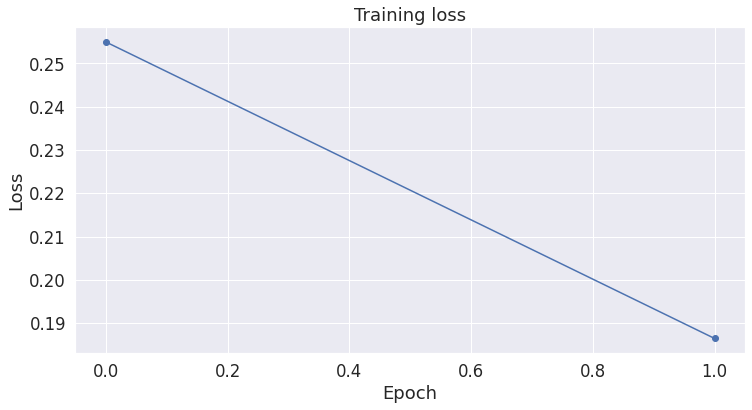

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## Saving Our Model

In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
output_dir = './model_save'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# This can be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./model_save


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/sentencepiece.bpe.model',
 './model_save/added_tokens.json')

In [ ]:
!ls -l --block-size=K ./model_save/

total 1091172K
-rw-r--r-- 1 root root       1K Feb 24 13:34 config.json
-rw-r--r-- 1 root root 1086203K Feb 24 13:34 pytorch_model.bin
-rw-r--r-- 1 root root    4951K Feb 24 13:34 sentencepiece.bpe.model
-rw-r--r-- 1 root root       1K Feb 24 13:34 special_tokens_map.json
-rw-r--r-- 1 root root       1K Feb 24 13:34 tokenizer_config.json


In [ ]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 1061M Feb 24 13:34 ./model_save/pytorch_model.bin


In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "./models/enja-binary-model/"

# Fine-Tuning XLM-R for Fine-Grained (5-stars) Sentiment Classification

## Load English and Japanese review data obtained from the Amazon Multilingual Review Dataset

In [ ]:
en_train_path = './data/amazon-enja-sentiment-dataset/dataset_en_train.json'
en_dev_path = './data/amazon-enja-sentiment-dataset/dataset_en_dev.json'
ja_train_path = './data/amazon-enja-sentiment-dataset/dataset_ja_train.json'
ja_dev_path = './data/amazon-enja-sentiment-dataset/dataset_ja_dev.json'

In [ ]:
import pandas as pd

# # english
# df_en = pd.read_json(en_train_path, lines=True)
# # japanese
# df_ja = pd.read_json(ja_train_path, lines=True)
# # concat
# df_train = pd.concat([df_en, df_ja])

# one lang only
df_train = pd.read_json(en_train_path, lines=True)

def label_sentiment (row):
    if row['stars'] == 1:
      return 0
    elif row['stars'] == 2:
      return 1
    elif row['stars'] == 3:
      return 2
    elif row['stars'] == 4:
      return 3
    elif row['stars'] == 5:
      return 4

df_train['sentiment'] = df_train.apply(lambda row: label_sentiment(row), axis=1)
#Shuffle (and sample) the data
df_train = df_train.sample(frac=1).reset_index(drop=True)
print(df_train.shape)

print('Total 1 star review: ', df_train.loc[df_train['sentiment'] == 0].shape[0])
print('Total 2 star review: ', df_train.loc[df_train['sentiment'] == 1].shape[0])
print('Total 3 star review: ', df_train.loc[df_train['sentiment'] == 2].shape[0])
print('Total 4 star review: ', df_train.loc[df_train['sentiment'] == 3].shape[0])
print('Total 5 star review: ', df_train.loc[df_train['sentiment'] == 4].shape[0])
df_train


(200000, 9)
Total 1 star review:  40000
Total 2 star review:  40000
Total 3 star review:  40000
Total 4 star review:  40000
Total 5 star review:  40000


,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,sentiment
0,en_0702817,product_en_0124032,reviewer_en_0672917,3,"Gotta force the headphone in, but once you do ...",A little finicky,en,wireless,2
1,en_0098220,product_en_0594788,reviewer_en_0872365,3,"Their ok, not steady, not exactly necessary.",Three Stars,en,beauty,2
2,en_0407051,product_en_0373879,reviewer_en_0209912,2,The arm on this holder is too weak to hold my ...,Weak,en,wireless,1
3,en_0319579,product_en_0124796,reviewer_en_0729633,5,Excellent product.. one bottle will last year ...,Great product,en,beauty,4
4,en_0682311,product_en_0321754,reviewer_en_0935263,2,"Material felt strange and stiff, not comfortable.",not comfortable.,en,shoes,1
...,...,...,...,...,...,...,...,...,...
199995,en_0836302,product_en_0047451,reviewer_en_0528262,5,"My kids love any kind of light, so I thought t...","very neat, rechargable light!",en,musical_instruments,4
199996,en_0879867,product_en_0091172,reviewer_en_0222372,5,"Works great, rapid charging of devices via the...",Fast charging 3.0 plug,en,wireless,4
199997,en_0464598,product_en_0730949,reviewer_en_0120813,1,Horrible product. If you want to waste your mo...,Doesn’t work,en,electronics,0
199998,en_0867061,product_en_0682220,reviewer_en_0972779,1,Cheap material. Poor craftsmanship in the embr...,Poor craftsmanship in the embroidery details,en,apparel,0


In [ ]:
# Get the lists of reviews and their binary sentiment labels.
reviews = df_train.review_body.values
sentiments = df_train.sentiment.values

In [ ]:
reviews

array(['Gotta force the headphone in, but once you do sound is great!',
       'Their ok, not steady, not exactly necessary.',
       'The arm on this holder is too weak to hold my iPhone XS Max', ...,
       'Horrible product. If you want to waste your money on a cheap stereo that doesn’t work, this product is for you. If i was able to give it negative stars I would. Don’t waste your money on cheap stereos like this. Get a name brand for 30$ more and save yourself the headache',
       'Cheap material. Poor craftsmanship in the embroidery details.',
       'I hate to say it, but this backpack is not as roomie as I thought it would be. Yes, I know is a camera bag and yes, it holds my camera things and computer very nicely. However, the compartment just above the camera barely has enough room for a composition book. I had to downsize my notebooks so that I could carry more than one at a time. Not entirely thrilled with my back pack. Overall: GOOD for small things and holding your camera

In [ ]:
sentiments

array([2, 2, 1, ..., 0, 0, 2])

## XLM-RoBERTa Tokenizer

In [ ]:
import torch
from transformers import XLMRobertaTokenizer

# Download the tokenizer for the XLM-Robert `base` model.
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

In [ ]:
tokenizer

PreTrainedTokenizer(name_or_path='xlm-roberta-base', vocab_size=250002, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True)})

In [ ]:
# Print the original sentence.
print(' Original: ', reviews[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(reviews[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(reviews[0])))

 Original:  Gotta force the headphone in, but once you do sound is great!
Tokenized:  ['▁Gott', 'a', '▁force', '▁the', '▁head', 'phone', '▁in', ',', '▁but', '▁once', '▁you', '▁do', '▁sound', '▁is', '▁great', '!']
Token IDs:  [38334, 11, 37772, 70, 10336, 26551, 23, 4, 1284, 24145, 398, 54, 45730, 83, 6782, 38]


## Convert Sentences to Input IDs


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in reviews:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        max_length = 128,          # Truncate all sentences.
                        truncation=True,
                        # return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', reviews[0])
print('Token IDs:', input_ids[0])

Original:  Gotta force the headphone in, but once you do sound is great!
Token IDs: [0, 38334, 11, 37772, 70, 10336, 26551, 23, 4, 1284, 24145, 398, 54, 45730, 83, 6782, 38, 2]


In [ ]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  128


## Pad and truncate our sequences so that they all have the same length, MAX_LEN=64.

In [ ]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 47...
MAX_LEN = 64

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 64 values...

Padding token: "<pad>", ID: 1

Done.


## The attention mask: Makes it explicit which tokens are actual words versus which are padding.

In [ ]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [ ]:
print(reviews[2])
print(tokenizer.tokenize(reviews[2]))
print(input_ids[2])
print(attention_masks[2])

The arm on this holder is too weak to hold my iPhone XS Max
['▁The', '▁arm', '▁on', '▁this', '▁holder', '▁is', '▁too', '▁we', 'ak', '▁to', '▁hold', '▁my', '▁iPhone', '▁XS', '▁Max']
[     0    581  16294     98    903  26837     83   5792    642    344
     47  16401    759   4289 112720   9920      2      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Train & Validation Split

In [ ]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, sentiments, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, sentiments, random_state=2018, test_size=0.1)

## Convert to PyTorch Data Types

In [ ]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
# We'll also create an iterator for our dataset using the torch DataLoader class. 
# This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory.

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

## Load XLM-R Model

In [ ]:
from transformers import XLMRobertaForSequenceClassification, AdamW, XLMRobertaConfig

# Load XLMRobertaForSequenceClassification, the pretrained XLMRoberta model with a single 
# linear classification layer on top. 
model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 5, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

XLMRobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

In [ ]:
# Check the model's parameter
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The XLM-RoBERTa model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The XLM-RoBERTa model has 201 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (250002, 768)
roberta.embeddings.position_embeddings.weight             (514, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias    

## Optimizer & Learning Rate Scheduler

Batch size: 16, 32 (We chose 32 when creating our DataLoaders).

Learning rate (Adam): 5e-5, 3e-5, 2e-5 (We'll use 2e-5).

Number of epochs: 2, 3, 4 (We'll use 4).

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
scheduler

## Training!
Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a training phase and a validation phase. At each pass we need to:

Training loop:
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

Evaluation loop:
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

So please read carefully through the comments to get an understanding of what's happening. If you're unfamiliar with pytorch a quick look at some of their [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) will help show you that training loops really involve only a few simple steps; the rest is usually just decoration and logging.  

In [ ]:
# Define a helper function for calculating accuracy.

import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
#Helper function for formatting elapsed times.

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  5,625.    Elapsed: 0:00:10.
  Batch    80  of  5,625.    Elapsed: 0:00:19.
  Batch   120  of  5,625.    Elapsed: 0:00:29.
  Batch   160  of  5,625.    Elapsed: 0:00:38.
  Batch   200  of  5,625.    Elapsed: 0:00:47.
  Batch   240  of  5,625.    Elapsed: 0:00:57.
  Batch   280  of  5,625.    Elapsed: 0:01:06.
  Batch   320  of  5,625.    Elapsed: 0:01:16.
  Batch   360  of  5,625.    Elapsed: 0:01:25.
  Batch   400  of  5,625.    Elapsed: 0:01:35.
  Batch   440  of  5,625.    Elapsed: 0:01:44.
  Batch   480  of  5,625.    Elapsed: 0:01:54.
  Batch   520  of  5,625.    Elapsed: 0:02:03.
  Batch   560  of  5,625.    Elapsed: 0:02:12.
  Batch   600  of  5,625.    Elapsed: 0:02:22.
  Batch   640  of  5,625.    Elapsed: 0:02:31.
  Batch   680  of  5,625.    Elapsed: 0:02:41.
  Batch   720  of  5,625.    Elapsed: 0:02:50.
  Batch   760  of  5,625.    Elapsed: 0:03:00.
  Batch   800  of  5,625.    Elapsed: 0:03:09.
  Batch   840  of

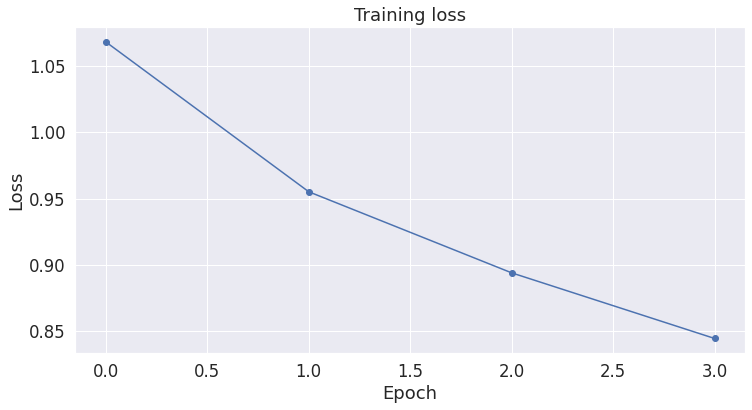

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## Saving Our Model

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))

Saving model to ./model_save


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/sentencepiece.bpe.model',
 './model_save/added_tokens.json')

In [ ]:
!ls -l --block-size=K ./model_save/

total 1091180K
-rw-r--r-- 1 root root       1K Mar  9 08:03 config.json
-rw-r--r-- 1 root root 1086212K Mar  9 08:03 pytorch_model.bin
-rw-r--r-- 1 root root    4951K Mar  9 08:03 sentencepiece.bpe.model
-rw-r--r-- 1 root root       1K Mar  9 08:03 special_tokens_map.json
-rw-r--r-- 1 root root       1K Mar  9 08:03 tokenizer_config.json


In [ ]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 1061M Mar  9 08:03 ./model_save/pytorch_model.bin


In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "./models/en-finegrained-model/"